In [7]:
import gym
from gym import wrappers
gym.logger.set_level(40)

import random
import numpy as np
import time

from collections import deque

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from IPython.display import clear_output

In [8]:
print("I am running keras version %s."%keras.__version__)

I am running keras version 2.2.4.


# Deep Q-Learning

### Cartpole explained
* The pendulum starts upright, and the goal is to prevent it from falling over. 
* A reward of +1 is provided for every timestep that the pole remains upright. 
* The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
* The system is controlled by applying a force of +1 or -1 to the cart (so only 2 actions)
* You can manually set the number of steps after which the episodes ends (standard at 200)

* A state consists of 4 numbers: position of cart, velocity of cart, angle of pole, rotation rate of pole
* Many different states so carving up a Q-table is not overly efficient

### Create Agent

In [9]:
class DQN_Agent(object):

    def __init__(self, input_dim, output_dim):
        self.epsilon = epsilon

        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # set memory for experience replay
        
        self.memory = deque(maxlen=memory_size)
        
        self.build_network(self.input_dim, self.output_dim)
        
    def build_network(self, input_dim, output_dim):
    
        # set up network for predicting Q-values
    
        self.model = Sequential([
        Dense(24, activation='relu', input_shape=(input_dim,)),
        Dense(24, activation='relu'),
        Dense(output_dim, activation='linear')])
    
        self.model.compile(loss="mse", optimizer=Adam(lr=learning_rate))
        
        #print(self.model.summary())
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, episode):
        
        if episode< exploration_rounds:
            action =  random.randrange(self.output_dim)
            return action
        
        elif episode > exploration_rounds and np.random.rand() > self.epsilon:
            q_values = self.model.predict(state)
            action = np.argmax(q_values[0])
            
            self.epsilon *= epsilon_decay
            self.epsilon = max(epsilon_min, self.epsilon)
            
            return action
        
        else:
            action =  random.randrange(self.output_dim)
            
            self.epsilon *= epsilon_decay
            self.epsilon = max(epsilon_min, self.epsilon)
            return action

    def experience_replay(self):
        if len(self.memory) < batch_size:
            return
        
        # randomly sample a state, reward combinations from our memory, update Q-values and train
        
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + gamma * np.amax(self.model.predict(state_next)[0]))
                
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
                        
            self.model.fit(state, q_values, verbose=0)
             
    def plot(self, episode, means_hist, num_episodes, max_episode_steps, start):
        clear_output(True)
        print("--- Epoch: %i ---"%episode)
        print("--- Mean reward: %i ---"%means_hist[-1])
        print('time elapsed (sec) =', time.time()-start)
        print('eps =', self.epsilon)

        size = (10, 5)
        fig, ax = pyplot.subplots(figsize=size)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=12)
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel('reward', fontsize=12)
        plt.xlim(0, num_episodes/10)
        plt.ylim(0, max_episode_steps)
        plt.plot(means_hist)

        if episode == num_episodes:
            plt.savefig('DQN.png')

        plt.show()

        time.sleep(0.25)


###  Play the game and train the network as we go

In [10]:
def run_episode(env, agent, episode, render):

    state = env.reset()
    state = np.reshape(state, [1, agent.input_dim])

    cumul_reward_episode = 0
    
    done = False

    while not done:
        
        if render: env.render()
        
        # get an action either through our network - or randomly
        
        action = agent.act(state, episode)
        
        # get next state and reward along our chosen action
        
        state_next, r, done, info = env.step(action)
        
        r = r if not done else -r
        
        cumul_reward_episode += r
        state_next = np.reshape(state_next, [1, agent.input_dim])
        
        # put state, action, corresponding reward and next state in our memory
        
        agent.remember(state, action, r, state_next, done)
        state = state_next
        
        # randomly sample a batch of state, reward combinations, update Q-values and update network weights
        
        agent.experience_replay()
    
    return cumul_reward_episode

In [11]:
def cartpole_dqn(num_episodes, max_episode_steps, epsilon, epsilon_decay, learning_rate, render):
    try:
        start = time.time()
    
        episodes_set = []
        cumul_rewards = []
        mean_rewards = deque(maxlen=10)
        means_hist = []
        
        # set up environment

        env = gym.make("CartPole-v0")
        env._max_episode_steps = max_episode_steps
        #env = wrappers.Monitor(env, './videos/' + str(time()) + '/')
        
        input_dim = env.observation_space.shape[0]
        output_dim = env.action_space.n
        
        # create DQN Agent
        
        agent = DQN_Agent(input_dim, output_dim)
        
        for episode in range(num_episodes+1):
            
            # run episode
            
            cumul_reward_episode = run_episode(env, agent, episode, render)
            
            episodes_set.append(episode)
            cumul_rewards.append(cumul_reward_episode)
            mean_rewards.append(cumul_reward_episode)
            
            if episode%10==0:

                means_hist.append(np.mean(mean_rewards))

                agent.plot(episode, means_hist, num_episodes, max_episode_steps, start)
                
        return episodes_set, cumul_rewards
    
    finally:
        env.close()

--- Epoch: 100 ---
--- Mean reward: 8 ---
time elapsed (sec) = 175.73059582710266
eps = 0.2


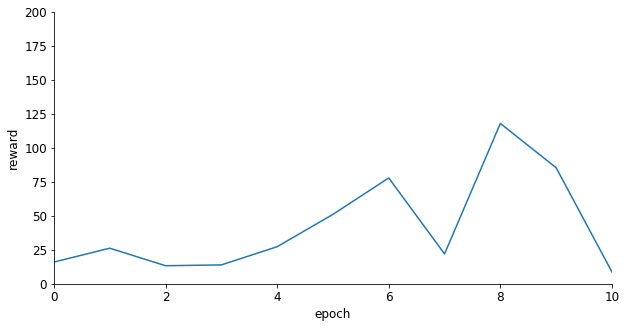

In [12]:
render = False
num_episodes = 100
exploration_rounds = 0
max_episode_steps = 200

gamma = 0.95
learning_rate = 0.001

memory_size = 1000
batch_size = 32

epsilon = 1.0
epsilon_min = 0.2
epsilon_decay = 0.999

episodes, cumul_rewards = cartpole_dqn(num_episodes, max_episode_steps, epsilon, epsilon_decay, learning_rate, render)